### Tipping points 
In this notebook, we will explore qualitative changes in the behavior of solutions as we vary a parameter in our model. Our focus is on tipping points at which the underlying system undergoes a large change as a parameter crosses a certain critical value. We focus on two applications that occur at vastly different scales, namely (1) sudden outbreaks of spruce budworm populations in forests and (2) the transition from our current climate to an ice age ("snowball earth"). We use scalar differential equations to model budworm populations and the global energy balance on earth. Before we discuss these applications, we consider a common ingredient of tipping-point transitions.

In [1]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.optimize import fsolve
from skimage import measure
import warnings

def bifurcation_analysis(f, dfdu, pars, T, prange, urange, Np, Nu, layout='vertical', yaxislabel='dependent variable'):

    def update_graph(r):
        x = np.linspace(urange[0], urange[1], 100)
        y = f(0, x, r, *pars)
        lineF.set_data(x, y)
        lineSelr.set_data([r, r], urange)

        fp, fpUnstable = find_equilibria(r)
        lineEqF.set_data(fp, 0*fp)
        lineEqC.set_data(r+0*fp, fp)

        fpData = np.array([[0],[0]])
        for pt in fp:
            fpData = np.concatenate((fpData, np.array([[0, T, np.nan], [pt, pt, np.nan]])), axis=1)
        lineEqSol.set_data(fpData[:,1:])

        icData = np.linspace(urange[0], urange[1], 10)
        if fpUnstable.size != 0:
            icData = np.concatenate((icData, fpUnstable-0.01, fpUnstable+0.01))
        solu = []
        solt = []
        for u0 in icData:
            sol = solve_ivp(f, [0, T], [u0], t_eval=t, args=[r, *pars], atol=1.e-8, rtol=1.e-6)
            solu = np.concatenate((solu, sol.y[0], [np.nan]))
            solt = np.concatenate((solt, sol.t, [np.nan]))
        lineSol.set_data(solt, solu)

    def find_equilibria(r):
        fp = np.array([])
        for tckCont in tck:
            bspl = tckCont.copy()
            bspl[1] = tckCont[1][0] - r
            pspl = interpolate.PPoly.from_spline(bspl, extrapolate=False)
            knots = pspl.roots()
            if knots.size != 0:
                fp = np.append(fp, interpolate.splev(knots, tckCont)[1])
        fpUnstable = np.array([])
        if fp.size != 0:
            ind = np.where(dfdu(0, fp, r, *pars) > 0)[0]
            fpUnstable = fp[ind]
        return [fp, fpUnstable]

    t = np.linspace(0, T, 100)
    u, r = np.ogrid[urange[0]:urange[1]:(Nu*1j), prange[0]:prange[1]:(Np*1j)]

    vf = f(0, u, r, *pars)
    rawcontours = measure.find_contours(vf, 0.)
    contours = np.array([[0],[0]])
    tck = []
    tplot = np.arange(0., 1., 0.001)

    warnings.filterwarnings('ignore', 'The iteration is not making good progress')
    for contour in rawcontours:
        contour[:, [0,1]] = contour[:, [1,0]]
        contour[:, 0] = prange[0] + (prange[1]-prange[0])*contour[:, 0]/Np
        contour[:, 1] = urange[0] + (urange[1]-urange[0])*contour[:, 1]/Nu
        for k in range(contour.shape[0]):
            fp = contour[k, :]
            if abs(dfdu(0, fp[1], fp[0], *pars))>0.1:
                contour[k,1] = fsolve(lambda x: f(0, x, fp[0], *pars), fp[1])
            else:
                contour[k,0] = fsolve(lambda x: f(0, fp[1], x, *pars), fp[0])
        tckCont, *_ = interpolate.splprep([contour[:, 0], contour[:, 1]], s=0)
        tck.append(tckCont)

    contours = np.concatenate(rawcontours, axis=0)
    evalue = dfdu(0, contours[:, 1], contours[:, 0], *pars)
    ind = np.where(evalue < 0)[0]
    fpStable = np.insert(contours[ind, :], 1 + np.where(np.diff(ind) > 1)[0], np.NaN, axis=0)
    ind = np.where(evalue > 0)[0]
    fpUnstable = np.insert(contours[ind, :], 1 + np.where(np.diff(ind) > 1)[0], np.NaN, axis=0)

    if layout=='vertical':
        fig, ax = plt.subplots(3, 1, figsize=(4,9))
    else:
        fig, ax = plt.subplots(1, 3, figsize=(10,3))
    lineF, = ax[0].plot([], [], linewidth=2, color="tab:green", zorder=2)
    lineEqF, = ax[0].plot([], [], c="tab:red", marker='o', ls='', zorder=3)
    ax[0].axhline(y=0, linewidth=1, color="tab:gray", alpha=0.5, zorder=1)
    ax[0].set_xlim(urange)
    ax[0].set_ylim(np.amin(vf), np.amax(vf))
    ax[0].set_xlabel(yaxislabel)
    ax[0].set_ylabel('model right-hand side')

    lineSol, = ax[1].plot([], [], linewidth=2, color="tab:blue", zorder=2)
    lineEqSol, = ax[1].plot([], [], linewidth=2, color="tab:red", zorder=2)
    ax[1].set_xlim(0, T)
    ax[1].set_ylim(urange)
    ax[1].set_xlabel('time t')
    ax[1].set_ylabel(yaxislabel)

    lineSelr, = ax[2].plot([], [], linewidth=2, color="tab:gray", zorder=2)
    lineEqC, = ax[2].plot([], [], c="tab:red", marker='o', ls='', zorder=3)
    extent = [prange[0], prange[1], urange[0], urange[1]]
    img = ax[2].imshow(vf, cmap=plt.cm.RdBu, norm=colors.TwoSlopeNorm(vcenter=0),
                       aspect='auto', extent=extent, origin='lower')
    ax[2].plot(fpStable[:, 0], fpStable[:, 1], color='tab:purple', linewidth=3, zorder=1)
    ax[2].plot(fpUnstable[:, 0], fpUnstable[:, 1], linestyle='dotted',
               color='tab:purple', linewidth=3, zorder=1)
    fig.colorbar(img,  ax=ax[2])
    ax[2].set_xlabel('model parameter')
    ax[2].set_ylabel(yaxislabel)

    widgets.interact(update_graph, r=widgets.FloatSlider(description='Parameter:', value=(prange[1]+prange[0])/2,
                                                         min=prange[0], max=prange[1], step=(prange[1]-prange[0])/20))   
    plt.tight_layout()
    plt.show()
    
    return [fpStable,  fpUnstable]

def tipping_point(fold_slow, fp, u0, pars, T, prange, urange, Nframes=100, Neval=50, yaxislabel='dependent variable'):
    def update_graph(k, u, Nframes, N, lineEP, lineSol):
        if k == 0:
            soln = u[:, 0:1]
        elif k == Nframes:
            soln = u
        else:
            soln = u[:, :k*N]
        lineSol.set_data(soln[0, :], soln[1, :])
        lineEP.set_data(soln[0, -1], soln[1, -1])

    def cross_top(t, x, *args): return urange[1] - x[1]
    def cross_bot(t, x, *args): return urange[0] - x[1]
    cross_top.terminal = True
    cross_bot.terminal = True

    fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.plot(fp[0][:,0], fp[0][:,1], color='tab:purple', linewidth=3, zorder=1)
    ax.plot(fp[1][:,0], fp[1][:,1], linestyle='dotted', color='tab:purple', linewidth=3, zorder=1)
    ax.plot(u0[0], u0[1], c="tab:gray", marker='o', ls='', zorder=3)
    lineEP, = ax.plot([], [], c="tab:red", marker='o', ls='', zorder=3)
    lineSol, = ax.plot([], [], linewidth=2, color="tab:blue", zorder=2)
    ax.set_xlim(prange)
    ax.set_ylim(urange)
    ax.set_xlabel('model parameter')
    ax.set_ylabel(yaxislabel)
    plt.tight_layout()
    plt.show()
    
    sol = solve_ivp(fold_slow, [0, T], u0, t_eval=np.linspace(0, T, Neval*Nframes),
                    events=[cross_top, cross_bot], args=[*pars], atol=1.e-8, rtol=1.e-6)
    Nframes = 1 + int(np.ceil(len(sol.y[0,:])/Neval))
    ani = animation.FuncAnimation(fig, update_graph, frames=range(0, Nframes),
                                  fargs=(sol.y, Nframes, Neval, lineEP, lineSol),
                                  interval=50, repeat=False)
    fig.canvas.draw()

### Tipping points via "fold bifurcations"
We consider the prototype system $\frac{du}{dt} = -(\mu + u^2)$, which exhibits a tipping point at $\mu=0$. To explore the behavior of solutions to this system as the parameter $\mu$ is varied, the next cell will generates several graphs organized in three panels. The first panel shows the graph of the right-hand side $f(u,\mu)=-(\mu+u^2)$ as a function of $u$ for a fixed value of  the parameter $\mu$: intersections with  the horizontal axis are marked in red and correspond to the equilibria. The second panel shows the equilibria and selected solutions $u(t)$ as functions of time $t$ for the same value of $\mu$. The third panel illustrates the $(\mu,u)$-plane: shown in purple is the curve $\mu=-u^2$ of all equilibria (solid=stable, dashed=unstable), while the colors of the background image reflect the values of the right-hand side $f(u,\mu)$. The vertical line is plotted at the current value of the parameter $\mu$. Use the slider at the bottom to vary the value of $\mu$ and explore the dynamics of the system.  

interactive(children=(FloatSlider(value=-0.25, description='Parameter:', max=0.5, min=-1.0, step=0.075), Outpu…

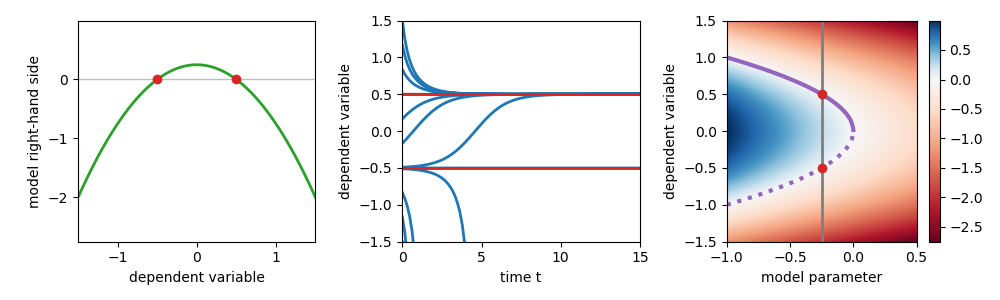

In [2]:
def fold(t, u, mu):
    return - (mu + u**2)

def fold_jac(t, u, mu):
    return -2*u

T = 15
prange=[-1.0, 0.5]
urange=[-1.5, 1.5]

fpFold = bifurcation_analysis(fold, fold_jac, [], T, prange, urange, Np=100, Nu=200, layout='horizontal')

The equilibria of this system are given by the points $(u,\mu)$ with $\mu=-u^2$ or, equivalently, by $u_\pm=\pm\sqrt{-\mu}$ where we need to restrict the parameter $\mu$ to negative values so that the square root is well defined. Hence, for each fixed $\mu<0$, the system has two equilibria, and we see that $u_+$ is stable, while $u_-$ is unstable. These two equilibria collide when $\mu=0$ and are no longer present for $\mu>0$. Thus, if we initialize our system with $u(0)=u_0>0$, the solution $u(t)$ will converge to $u_+(\mu)$ as $t\to\infty$ when $\mu\leq0$. However, for $\mu>0$, the solution will converge to $-\infty$! As $\mu$ crosses zero, the long-time behavior of the system therefore changes drastically.

#### Encountering tipping points
Imagine now that the parameter $\mu$ changes very slowly in time: as an example, we will choose $\mu(t)=-0.9+0.001\,t$. Starting with $u(0)=1.4$, the corresponding solution should approach $u_+$ rapidly since $\mu(0)=-0.9<0$ is negative. As $t$ increases, $\mu=\mu(t)$ will increase slowly, and our solution should closely follow the curve $u=u_-(\mu(t))$ of equilibria. Once $t$ is so large that $\mu(t)>0$, the solution $u(t)$ will approach $-\infty$. The animation in the following cell allows us to test this intuition.

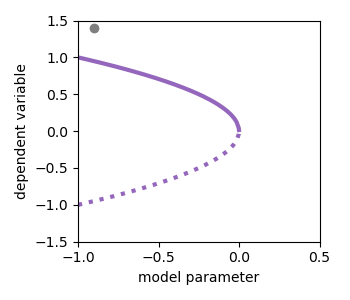

In [3]:
def fold_tipping(t, u):
    f1 = 0.001
    f2 = fold(t, u[1], u[0])
    return [f1, f2]

u0 = [-0.9, 1.4]
T = 1000
Nframes = 100
Neval = 50
pars = []

tipping_point(fold_tipping, fpFold, u0, pars, T, prange, urange, Nframes, Neval)

### Modeling spruce budworm populations
The larvae (caterpillars) of spruce budworms (several species in the Choristoneura genus of moths) feed on the buds and needles of spruce and fir. The figure below (taken from the 2011 R10-TP-152 spruce budworm leaflet of the USDA) shows the caterpillars (left) and the adult moths (right). Normally, budworm populations stay low, but there are significant outbreaks every 30-70 years that can lead to complete defoliation and devastating damage to forests. We explore a model of the budworm population that builds on the logistic equation and adds predation by birds who normally control budworm populations. We denote the population of budworms at time $t$ by $u(t)$ and consider the non-dimensionalized model
$$\frac{du}{dt}=ru(1-u/K)-\frac{u^2}{1+u^2},$$
where $r$ corresponds to the growth rate of budworms at small populations, and $K$ is the carrying capacity. The term $u^2/(1+u^2)$ models predation by a constant population of opportunistic birds: For small budworm populations $u$, birds will look for other prey, which is reflected by the fact that $u^2/(1+u^2)$ is small when $u$ is small. For large budworm populations, birds will prey on budworms, but since the bird population stays constant, the number of budworms eaten by birds approaches a constant when $u$ increases, which is indeed the case for the term $u^2/(1+u^2)$ which converges to one as $u$ increases. We now plot the same graphs as for the preceding system. We will set $K=10$ and vary the growth rate  $r$ in the interval $[0.2,0.7]$.

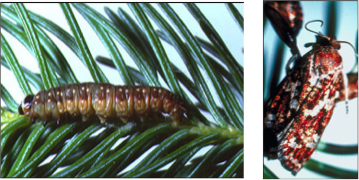

interactive(children=(FloatSlider(value=0.44999999999999996, description='Parameter:', max=0.7, min=0.2, step=…

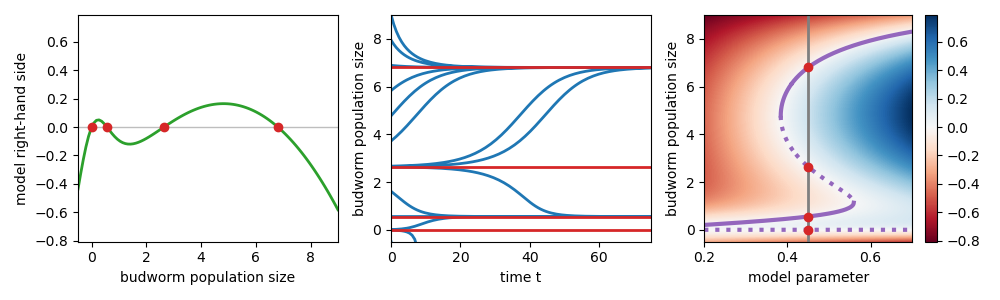

In [4]:
def budworm(t, u, r, K):
    return r*u*(1-u/K) - u*u/(1+u*u)

def budworm_jac(t, u, r, K):
    return r*(1-2*u/K) - 2*u*( 1/(1+u*u) - u*u/(1+u*u)**2 )

K = 10
T = 75
prange = [0.2, 0.7]
urange = [-0.5, 9]

fpBudworm = bifurcation_analysis(budworm, budworm_jac, [K], T, prange, urange, Np=100, Nu=1000, layout='horizontal', yaxislabel='budworm population size')

Next, we consider  the case where the spruce fir forest grows slowly over time and therefore provides an increasing amount of food resources for the budwork population. If the budworm population becomes too large, the spruce firs will die due to overfeeding of the budworms. To model this situation, we allow the parameter $r$ to change slowly in time. For small budworm population, the growth rate $r$ will slowly increase in time, while it will decrease slowly for large budworm populations. We start the differential equation for the time-dependent vector $(r,u)$ with the initial condition $(r_0,u_0)=(0.21, 2)$. The following simulation shows that as the growth rate $r$ increases slowly in time the budworm population will slowly increase by tracking the stable lower equilibrium branch. Once $r(t)$ reaches the rightmost fold where the equilibrium disappears, the population jumps upwards to the upper stable equilibrium, thus indicating a sudden outbreak of these insects. Since $r(t)$ now decreases, the budworm population will track the stable upper equilibrium branch until $r(t)$ reaches the leftmost fold, where the budworm population will collapse to the lower equilibrium. This process now repeats itself.

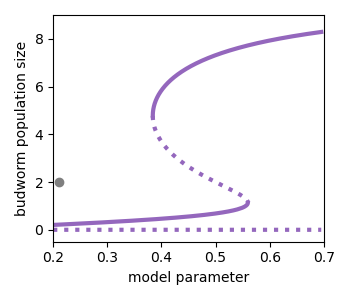

In [5]:
def budworm_tipping(t, u, K):
    f1 = 0.0005*np.sign(K/3-u[1])
    f2 = budworm(t, u[1], u[0], K)
    return [f1, f2]

K = 10
u0 = [0.21, 2.0]
T = 2000
Nframes = 300
Neval = 100

tipping_point(budworm_tipping, fpBudworm, u0, [K], T, prange, urange, Nframes, Neval, yaxislabel='budworm population size')

### Global energy climate models
Models of the earth's energy balance can also exhibit tipping points. Here, we focus on a one-dimensional model of the average surface temperature. Using a compartment model, this model is given by
$$C\frac{dT}{dt} = E_\mathrm{in}-E_\mathrm{out},$$
where $T(t)$ is the average surface  temperature at time $t$, $C$ is the heat capacity (the energy per area needed to raise the temperature by one Kelvin), and the two terms on the right-hand side are the rates at which energy per area is absorbed or emitted per unit time. The energy  per area emitted from the sun and reaching earth is given by $Q$. A fraction $\alpha$ of this energy is reflected back into space (e.g. by ice), and we therefore have $E_\mathrm{in}=(1-\alpha)Q$, where $\alpha$ is usually referred to as the albedo. Earth emits energy in the infrared regime, where it acts as a back body. The outgoing energy per area depends on the temperature and is given by $E_\mathrm{in}=\epsilon\sigma T^4$, where $\sigma$ is the Stefan constant, and $0<\epsilon<1$ accounts for the fact that the earth is not a perfect black body due to greenhouse effects. Our model therefore becomes
$$\frac{dT}{d\tau} = (1-\alpha)Q - \epsilon\sigma T^4,$$
where we use the normalized time variable $\tau:=t/C$. The albedo $\alpha$ depends on the temperature $T$ since water turns into ice for lower temperatures, thus increasing the albedo. We use the function $\alpha=\alpha(T)=0.5-0.2\tanh((T-260)/10)$ to model this effect. Our final model is given by
$$\frac{dT}{d\tau} = (1-\alpha(T))Q - \epsilon\sigma T^4, \qquad \alpha(T)=0.5-0.2\tanh((T-260)/10).$$
We now explore the dynamics of this model when we change the solar constant $Q$ from its current value $Q_0$, using the parameter $\mu=Q/Q_0$ near one. The graphs below show that there are regions with two stable equilibrium temperatues, given by the current climate and a "snowball earth" climate with significantly lower mean temperature. Transitions between these two states occur again via tipping points as $\mu$ is decreased or increased.

interactive(children=(FloatSlider(value=1.05, description='Parameter:', max=1.3, min=0.8, step=0.025), Output(…

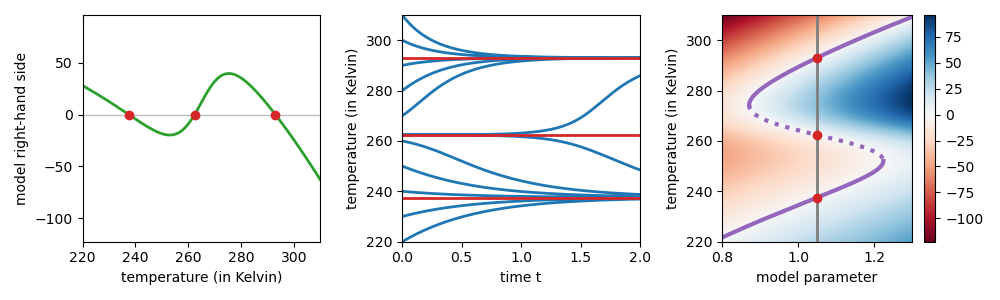

In [6]:
def climate(t, T, mu, epsilon, sigma, Q0):
    alpha = 0.5 - 0.2*np.tanh((T-265)/10)
    return (1-alpha)*Q0*mu - epsilon*sigma*T**4

def climate_jac(t, T, mu, epsilon, sigma, Q0):
    alpha = 0.5 - 0.2*np.tanh((T-265)/10)
    dalpha = -0.2/10*(1.0-np.tanh((T-265)/10)**2)
    return - dalpha*Q0*mu - 4*epsilon*sigma*T**3

pars = [0.6, 5.67e-08, 342]
T = 2
prange = [0.8, 1.3]
urange = [220, 310]

fpClimate = bifurcation_analysis(climate, climate_jac, pars, T, prange, urange, Np=1000, Nu=1000, layout='horizontal', yaxislabel='temperature (in Kelvin)')